# 音のバイナリデータをNumpyで扱える形にする

In [1]:
import numpy as np
import wave
import pyaudio
import matplotlib.pyplot as plt
import struct

# ファイル読み込み

In [16]:
def load_wav_file(Filename):
    try:
        wf = wave.open(Filename, "r")
    except FileNotFoundError:  # ファイルが存在しなかった場合
        print("No such file or directory: " + Filename)
        return 0

    return wf

In [17]:
wf = load_wav_file("sample/input2_mono.wav")

https://qiita.com/Dsuke-K/items/2ad4945a81644db1e9ff

In [18]:
# wavファイルの情報を取得
# チャネル数：monoなら1, stereoなら2, 5.1chなら6(たぶん)
nchannles = wf.getnchannels()

# 音声データ1サンプルあたりのバイト数。2なら2bytes(16bit), 3なら24bitなど
samplewidth = wf.getsampwidth()

# サンプリング周波数。普通のCDなら44.1k
framerate = wf.getframerate()

# 音声のデータ点の数
nframes = wf.getnframes()

print("Channel num : ", nchannles)
print("Sample width : ", samplewidth)
print("Sampling rate : ", framerate)
print("Frame num : ", nframes)

Channel num :  1
Sample width :  2
Sampling rate :  44100
Frame num :  1334218


# バイナリを読み込み、Numpyで使える形に

In [19]:
buf = wf.readframes(nframes)

In [20]:
if samplewidth == 2:
    data = np.frombuffer(buf, dtype="int16")
elif samplewidth == 4:
    data = np.frombuffer(buf, dtype="int32")

In [21]:
len(data)

1334218

In [26]:
type(data)

numpy.ndarray

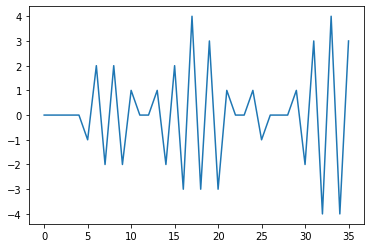

In [24]:
plt.plot(data[0:36])

In [25]:
sp = data[0:36]

# 窓をかける

In [31]:
window_x = np.linspace(0, 1, 36)
window_y = np.sin(np.pi / 2 * (np.sin(np.pi * window_x) ** 2))

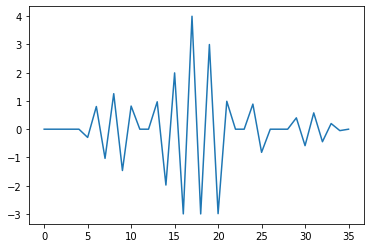

In [33]:
sp = sp * window_y
plt.plot(sp)

# DCTする

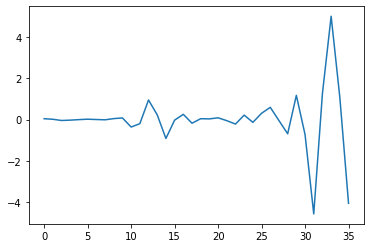

In [66]:
import scipy

c = scipy.fftpack.dct(sp, norm="ortho")
plt.plot(c)

# 間引きしてみる

周波数帯を等分割して、周波数の数を1/4に減らしてみる  
4サンプルの中で一番大きな周波数成分を出力候補とする

In [67]:
index = 0
thinning_freq = np.zeros(36)

while index + 4 < len(c) + 1:
    max_index = np.argmax(np.abs(c[index : index + 4]))
    thinning_freq[max_index + index] = c[max_index + index]
    index = index + 4

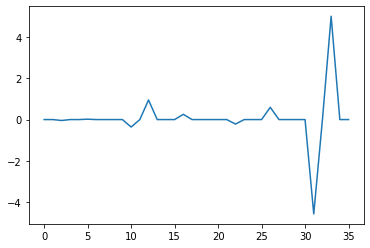

In [68]:
plt.plot(thinning_freq)

# 逆DCTする

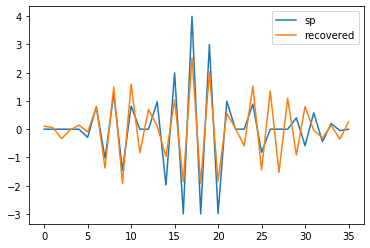

In [71]:
recovered = scipy.fftpack.idct(thinning_freq, norm="ortho")
plt.plot(sp, label="sp")
plt.plot(recovered, label="recovered")
plt.legend()

# 処理を最初から最後までやってみる

In [77]:
import numpy as np
import scipy
import wave
import pyaudio
import matplotlib.pyplot as plt
import struct

In [109]:
# SAMPLE_RANGE = 36
SAMPLE_RANGE = 1024
loop = len(data) // SAMPLE_RANGE

# 窓関数を確保
window_x = np.linspace(0, 1, SAMPLE_RANGE)
window_y = np.sin(np.pi / 2 * (np.sin(np.pi * window_x) ** 2))

result = np.zeros(len(data))

In [110]:
for loop_count in range(loop):
    if loop_count is 0:
        sp = data[loop_count * SAMPLE_RANGE : loop_count * SAMPLE_RANGE + SAMPLE_RANGE]
        sp = sp * window_y

        c = scipy.fftpack.dct(sp, norm="ortho")

        index = 0
        thinning_freq = np.zeros(SAMPLE_RANGE)
        while index + 4 < len(c) + 1:
            max_index = np.argmax(np.abs(c[index : index + 4]))
            thinning_freq[max_index + index] = c[max_index + index]
            index = index + 4

        recovered = scipy.fftpack.idct(thinning_freq, norm="ortho")
        result[
            loop_count * SAMPLE_RANGE : loop_count * SAMPLE_RANGE + SAMPLE_RANGE
        ] += recovered
    else:
        sp = data[
            loop_count * SAMPLE_RANGE
            - SAMPLE_RANGE // 2 : loop_count * SAMPLE_RANGE
            + SAMPLE_RANGE // 2
        ]
        sp = sp * window_y

        c = scipy.fftpack.dct(sp, norm="ortho")

        index = 0
        thinning_freq = np.zeros(SAMPLE_RANGE)
        while index + 4 < len(c) + 1:
            max_index = np.argmax(np.abs(c[index : index + 4]))
            thinning_freq[max_index + index] = c[max_index + index]
            index = index + 4

        recovered = scipy.fftpack.idct(thinning_freq, norm="ortho")

        result[
            loop_count * SAMPLE_RANGE
            - SAMPLE_RANGE // 2 : loop_count * SAMPLE_RANGE
            + SAMPLE_RANGE // 2
        ] += recovered

In [112]:
result_bin = [int(x) for x in result]
result_bin = struct.pack("h" * len(result_bin), *result_bin)

import pyaudio

# ストリームを開く
p = pyaudio.PyAudio()
stream = p.open(
    format=pyaudio.paInt16,
    channels=1,
    output_device_index=7,
    rate=int(44100),
    output=True,
)
# チャンク単位でストリームに出力し音声を再生
chunk = 1024
sp = 0  # 再生位置ポインタ
buffer = result_bin[sp : sp + chunk]
while buffer != b"":
    stream.write(buffer)
    sp = sp + chunk
    buffer = result_bin[sp : sp + chunk]
stream.close()
p.terminate()

SAMPLE_RANGE=32だと音質くそみたいになるんやけど...。  
SAMPLE_RANGE=1024だと若干ましになるけど、それでもひどい。何が違うんやろ。